In [2]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Read Dicom

In [3]:
def read_dicom(path):
    g = glob.glob(os.path.join(path, '*.dcm'))
    slices = [pydicom.read_file(s) for s in g]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    print('RescaleIntercept :{}'.format(slices[0].RescaleIntercept))
    print('RescaleSlope :{}'.format(slices[0].RescaleSlope))
    print('SliceThickness :{}'.format(slices[0].SliceThickness))
    print('Pixel Spacing  :{}'.format(slices[0].PixelSpacing ))

    return slices

In [4]:
def hu_window(scan, window_level=40, window_width=80, show_hist = False):
    scan = scan.pixel_array.copy()
    window = [window_level-window_width/2, window_width/2-window_level]
    
    scan = np.where(scan < window[0], window[0], scan)
    scan = np.where(scan > window[1], window[1], scan)
    
    if show_hist:
        plt.figure(0, figsize=(6,6))
        plt.imshow(scan, 'gray')

        plt.figure(1, figsize=(6,6))
        plt.hist(scan.flatten(), color='c')
        plt.xlabel("Hounsfield Units (HU)")
        plt.ylabel("Frequency")
        plt.show()

    return scan

In [5]:
def show_raw_pixel(slices):
    #讀出像素值並且儲存成numpy的格式
    image = hu_window(slices, window_level=0, window_width=1000,  show_hist=False)
#     plt.figure(figsize = (12,12))
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()

In [6]:
# return  a region where cbct images aren't all black
def valid_slices(cbcts, cts):
    found_start = False
    start = 0
    end = -1
    
    # iterate through cbct slices, and find which regions aren't all black (-1000)
    for idx, sli in enumerate(cbcts):
        image = sli.pixel_array
        
        if not found_start and len(np.unique(image))!=1:
            start = idx
            found_start = True
                                   
        elif found_start and len(np.unique(image)) == 1:
            end = idx
            break
        
    return start, end
                                   

## read two slices

In [141]:
case_path = '/home/jeff/文件/012'

In [17]:
paths = sorted(glob.glob('/home/jeff/文件/*_*'))
paths

['/home/jeff/文件/004_cbct',
 '/home/jeff/文件/004_ct',
 '/home/jeff/文件/006_cbct',
 '/home/jeff/文件/006_ct',
 '/home/jeff/文件/007_cbct',
 '/home/jeff/文件/007_ct',
 '/home/jeff/文件/012_cbct',
 '/home/jeff/文件/012_ct']

In [20]:
for i in range(0, len(paths), 2):
    print(paths[i], "   ", paths[i+1])

/home/jeff/文件/004_cbct     /home/jeff/文件/004_ct
/home/jeff/文件/006_cbct     /home/jeff/文件/006_ct
/home/jeff/文件/007_cbct     /home/jeff/文件/007_ct
/home/jeff/文件/012_cbct     /home/jeff/文件/012_ct


In [142]:
print('cbct')
cbct_slices = read_dicom(case_path + '_cbct')
print('ct')
ct_slices = read_dicom(case_path + '_ct')

cbct
RescaleIntercept :0
RescaleSlope :1
SliceThickness :5
Pixel Spacing  :[.8828125, .8828125]
ct
RescaleIntercept :0
RescaleSlope :1
SliceThickness :5
Pixel Spacing  :[.8828125, .8828125]


In [143]:
len(cbct_slices), len(ct_slices)

(112, 112)

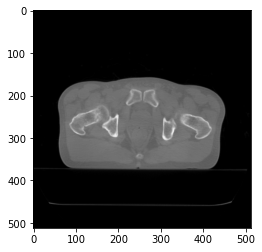

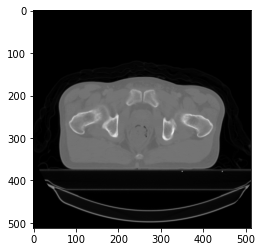

In [144]:
show_raw_pixel(cbct_slices[30])
show_raw_pixel(ct_slices[30])

# Window level

https://www.facebook.com/199733860383857/posts/490663181290922/

CT的深淺由CT number的大小來決定，然而CT number的跨越相當的廣，由空氣的-1000到骨頭的+1000，但人眼所能辨識的灰階數大約只有256種，在這種限制下，我們便會針對不同的需求，設計不同的Window Width(WW)和Window Level(WL)。
.
WL就像是中間值的概念，WW則是CT number橫跨的範圍，舉例來說，當設定WL=40, WW=400時，我們所看到的範圍將在-160~240之間，小於-160的就是全黑而大於240則是全白，如此一來，根據不同的部位就會有不同的設定值，像是Lung window , Bone window…..等等。

In [95]:
# brain W:80 L:40
# subdural W:130-300 L:50-100
# stroke W:8 L:32 or W:40 L:40 3
# temporal bones W:2800 L:600
# soft tissues: W:350–400 L:20–60 4
# chest
# lungs W:1500 L:-600
# mediastinum W:350 L:50
# abdomen
# soft tissues W:400 L:50
# liver W:150 L:30
# spine
# soft tissues W:250 L:50
# bone W:1800 L:400

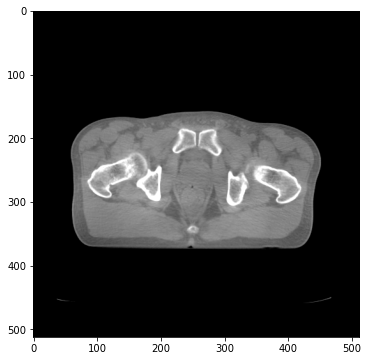

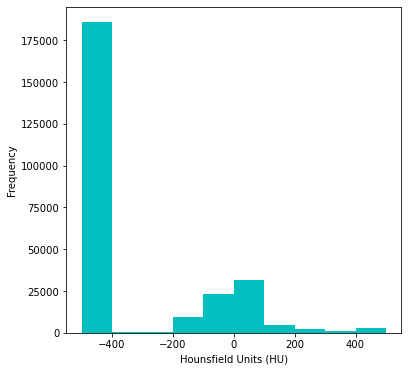

array([[-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       ...,
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.]])

In [153]:
hu_window(cbct_slices[30], window_level=0, window_width=1000, show_hist=True)

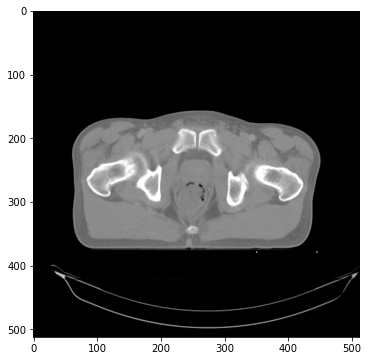

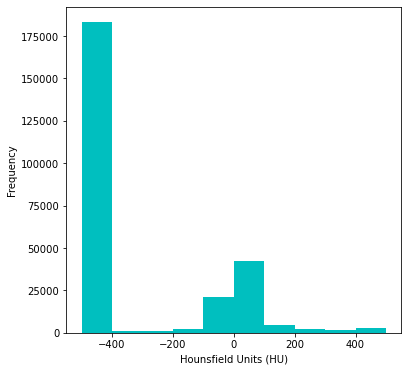

array([[-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       ...,
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.],
       [-500., -500., -500., ..., -500., -500., -500.]])

In [154]:
hu_window(ct_slices[30], window_level=0, window_width=1000,  show_hist=True)

# show all slices

## find slices where cbct are not all black

In [158]:
region = valid_slices(cbct_slices, ct_slices)
region

(23, 56)

In [159]:
# ditch first and last 3
region[0] + 3, region[1] - 3

(26, 53)

23


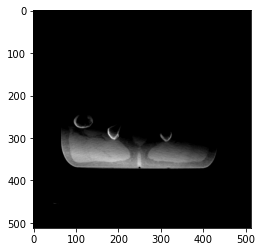

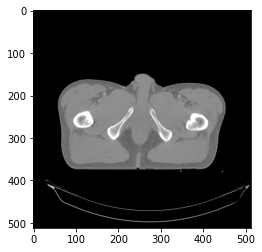

24


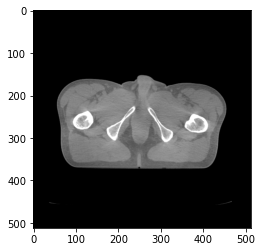

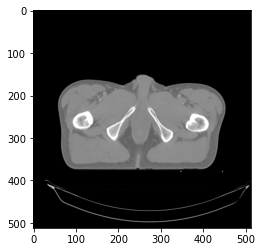

25


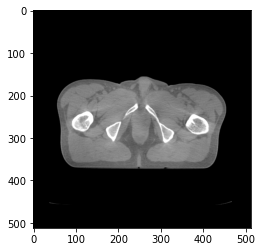

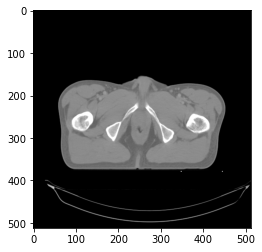

26


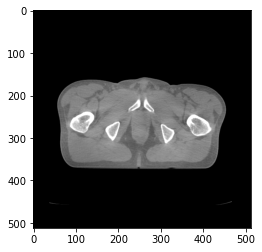

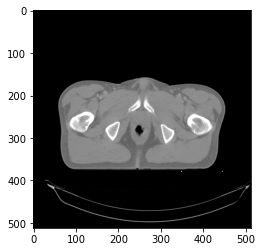

27


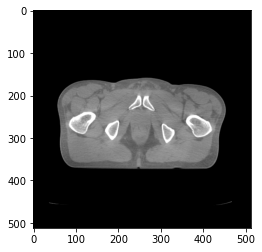

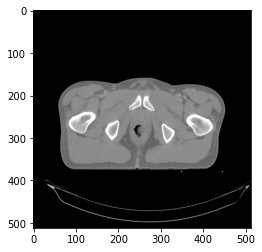

28


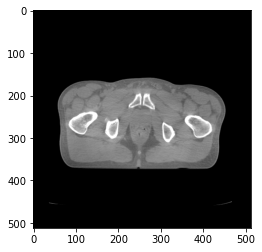

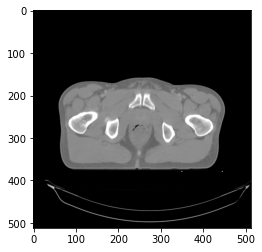

29


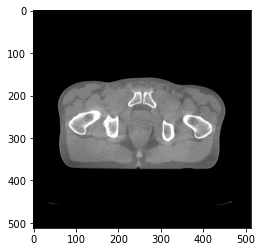

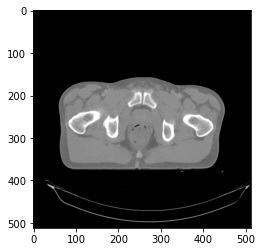

30


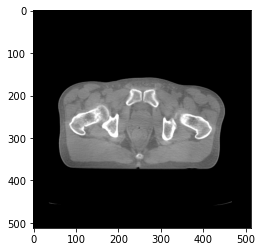

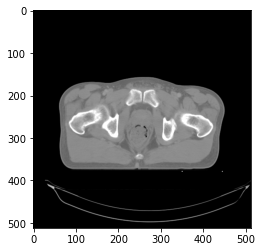

31


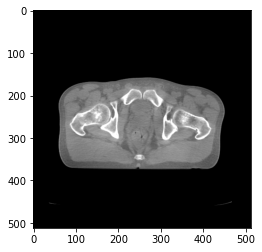

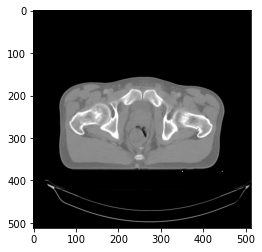

32


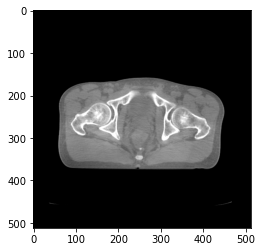

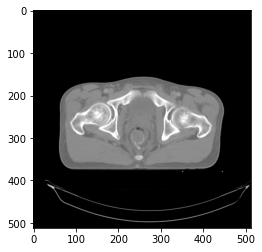

33


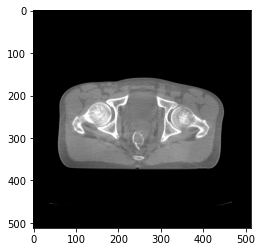

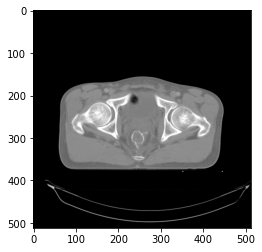

34


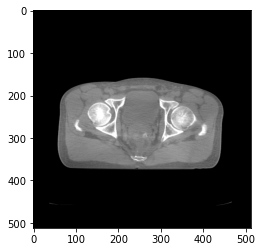

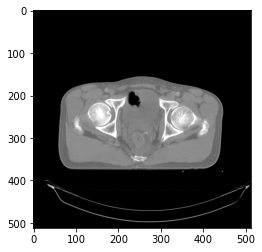

35


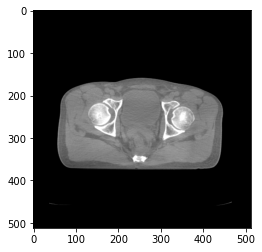

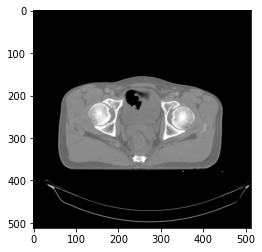

36


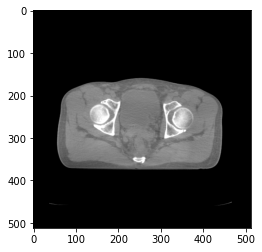

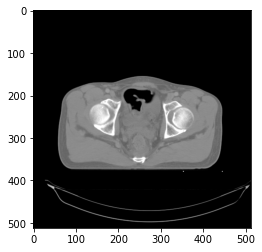

37


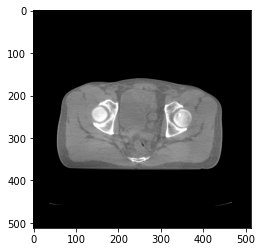

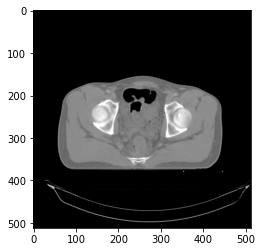

38


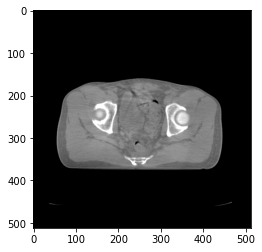

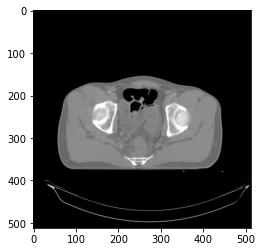

39


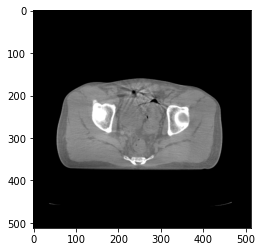

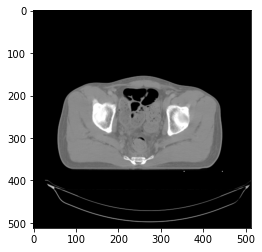

40


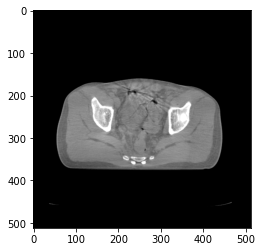

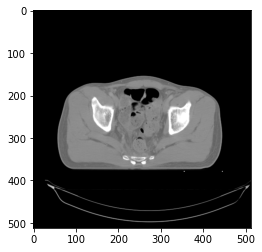

41


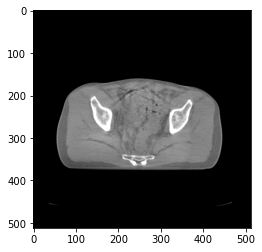

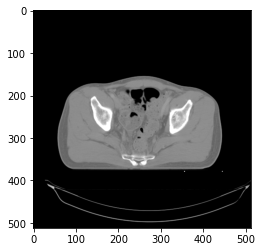

42


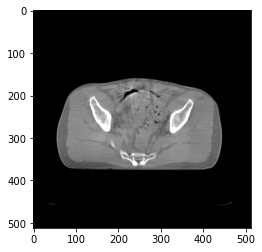

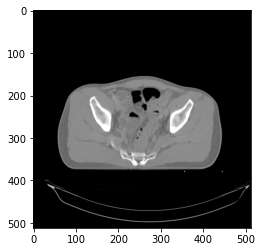

43


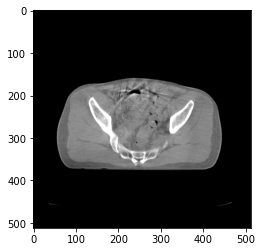

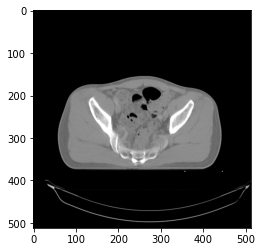

44


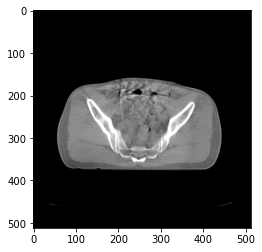

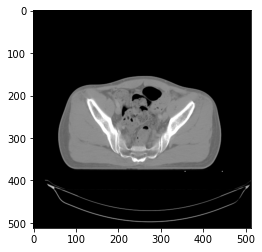

45


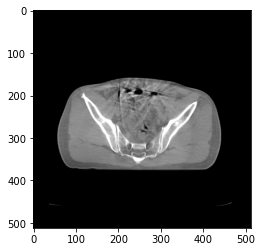

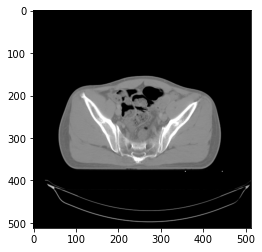

46


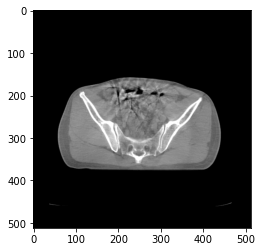

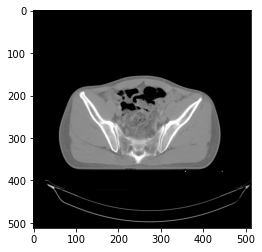

47


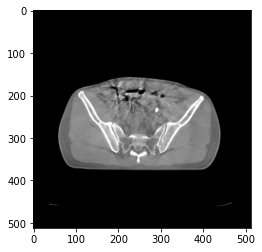

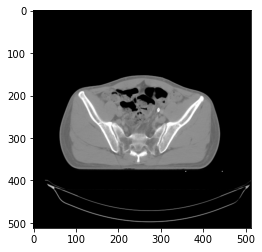

48


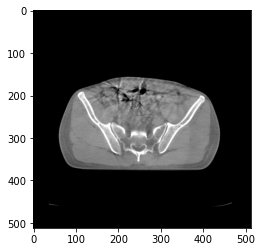

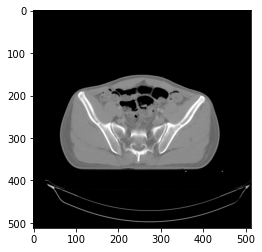

49


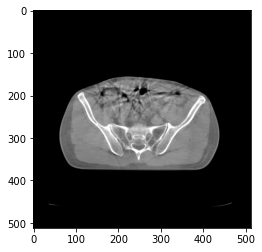

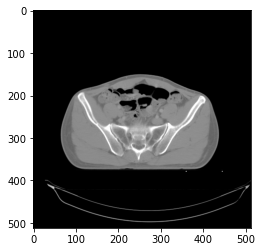

50


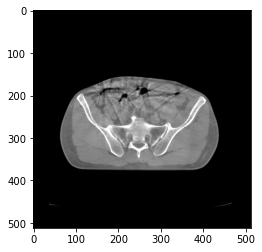

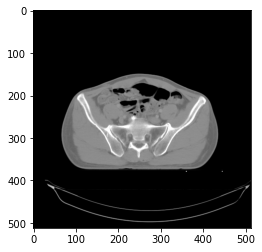

51


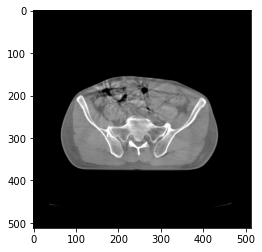

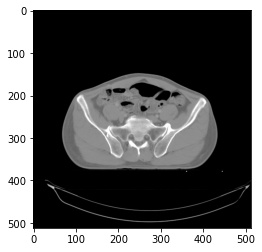

52


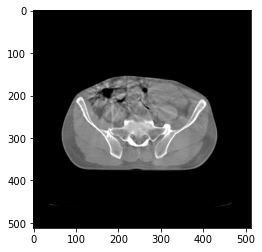

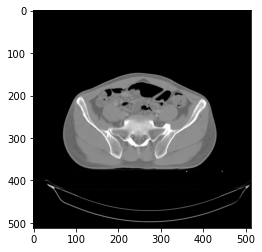

53


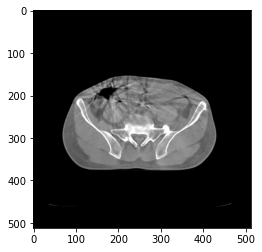

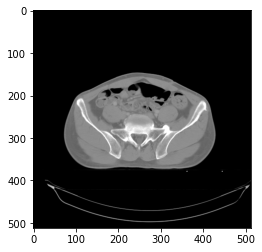

54


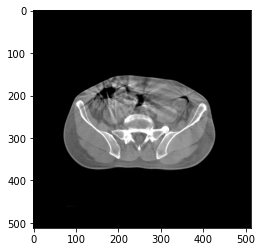

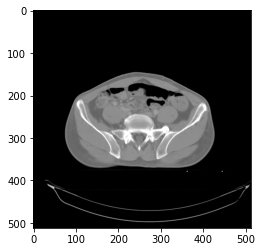

55


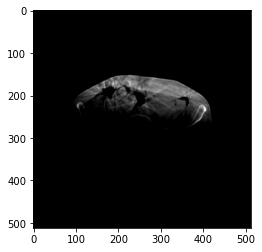

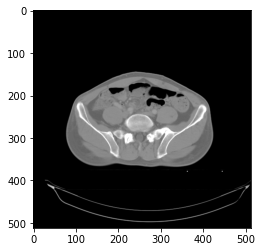

In [160]:
for i in range(*region):
    print(i)
    show_raw_pixel(cbct_slices[i])
    show_raw_pixel(ct_slices[i])
    print('=======================')